In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("/content/drive/MyDrive/santander/train.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.0,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
print(cust_df['TARGET'].value_counts())

unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1]['TARGET'].count()
total_cnt = cust_df['TARGET'].count()

print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [6]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

In [7]:
print(cust_df['var3'].value_counts()[:10])

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


In [8]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리, 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
print('피처 데이터 shape: {0}'.format(X_features.shape))

피처 데이터 shape: (76020, 369)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random_state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train , y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

In [16]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7], 'min_child_weight':[1,3],'colsample_bytree':[0.5,0.75]}

# 하이퍼 파라미터 테스트의 수행속도를 향상 시키기 위해 cv를 지정하지 않음
gridcv = GridSearchCV(xgb_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터: ',gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.716371	validation_1-auc:0.721224
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.808233	validation_1-auc:0.811497
[2]	validation_0-auc:0.804883	validation_1-auc:0.804536
[3]	validation_0-auc:0.815261	validation_1-auc:0.81637
[4]	validation_0-auc:0.825247	validation_1-auc:0.824507
[5]	validation_0-auc:0.819668	validation_1-auc:0.820074
[6]	validation_0-auc:0.818989	validation_1-auc:0.819519
[7]	validation_0-auc:0.824907	validation_1-auc:0.825344
[8]	validation_0-auc:0.828985	validation_1-auc:0.828536
[9]	validation_0-auc:0.827021	validation_1-auc:0.825688
[10]	validation_0-auc:0.83165	validation_1-auc:0.828585
[11]	validation_0-auc:0.834058	validation_1-auc:0.831318
[12]	validation_0-auc:0.836334	validation_1-auc:0.832347
[13]	validation_0-auc:0.835441	validation_1-auc:0.831432
[14]	validation_0-auc:0.834861	validation_1-auc:0.830882


KeyboardInterrupt: ignored

In [18]:
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,\
                       min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# evaluation metric을 auc로, early stopping은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
            eval_metric="auc", eval_set=[(X_train,y_train), (X_test,y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.815226
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.827094	validation_1-auc:0.816566
[2]	validation_0-auc:0.832027	validation_1-auc:0.820393
[3]	validation_0-auc:0.835873	validation_1-auc:0.825019
[4]	validation_0-auc:0.838197	validation_1-auc:0.826078
[5]	validation_0-auc:0.837948	validation_1-auc:0.827282
[6]	validation_0-auc:0.8381	validation_1-auc:0.826888
[7]	validation_0-auc:0.838475	validation_1-auc:0.827131
[8]	validation_0-auc:0.839775	validation_1-auc:0.828198
[9]	validation_0-auc:0.83981	validation_1-auc:0.827834
[10]	validation_0-auc:0.841664	validation_1-auc:0.828996
[11]	validation_0-auc:0.841069	validation_1-auc:0.82802
[12]	validation_0-auc:0.841167	validation_1-auc:0.828517
[13]	validation_0-auc:0.841455	validation_1-auc:0.828317
[14]	validation_0-auc:0.845308	validation_1-auc:0.834099
[1

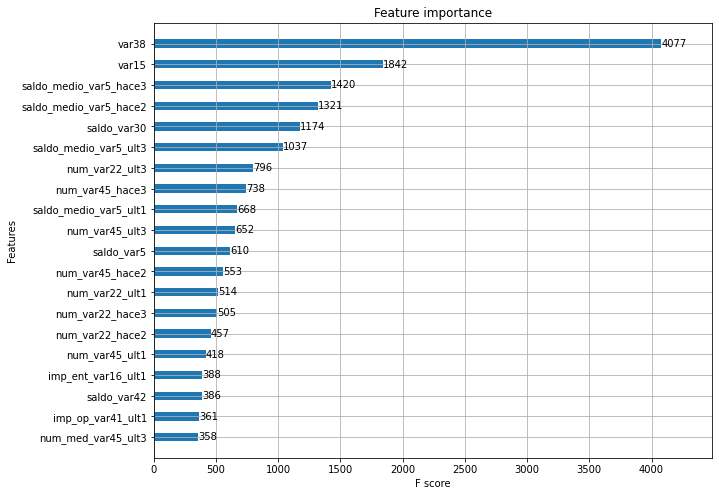

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)